- plot avg game count per depth
- pieces left / captured  not liguistics based
- how structured is the language of chess (random words) compared to the language of stockfish
    - grammar extraction
    - 

In [2]:
import sqlite3
from concurrent.futures import ProcessPoolExecutor

import chess
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.drawing.nx_pydot import graphviz_layout
from tqdm.notebook import tqdm

from scripts.db_utils import fetch_moves, fetch_games

In [61]:
from scripts.db_utils import fetch_games


DB_PATH = "data/chess_games_1.db"
N_GAMES = 1000  # 2000
DEPTH = 300


def process_game(game_id):
    game_id = int(game_id)
    local_graph = nx.DiGraph()
    board = chess.Board()
    board.reset()
    prev_board_fen = board.fen().split(" ")[0]
    local_graph.add_node(prev_board_fen, visit_count=0, move_number=[0])

    df = fetch_moves(
        DB_PATH,
        filters=[("game_id", "=", game_id), ("move_number", "<=", DEPTH)],
        columns=["move_number", "board_fen"],
    )
    for move_number, board_fen in df.values:
        board_fen = board_fen.split(" ")[0]
        if board_fen not in local_graph.nodes:
            local_graph.add_node(board_fen, visit_count=1) # ,  move_number=[move_number])
        else:
            # local_graph.nodes[board_fen]["move_number"].append(move_number)
            local_graph.nodes[board_fen]["visit_count"] += 1

        if (prev_board_fen, board_fen) not in local_graph.edges:
            local_graph.add_edge(
                prev_board_fen, board_fen, visit_count=1, # move_number=[move_number]
            )
        else:
            # local_graph.edges[(prev_board_fen, board_fen)]["move_number"].append(move_number)
            local_graph.edges[(prev_board_fen, board_fen)]["visit_count"] += 1

        prev_board_fen = board_fen
    return local_graph


def merge_graphs(main_graph, partial_graph):
    for node, data in partial_graph.nodes(data=True):
        if node not in main_graph:
            main_graph.add_node(node, visit_count=data["visit_count"])
        else:
            main_graph.nodes[node]["visit_count"] += data["visit_count"]
            # main_graph.nodes[node]["move_number"].extend(data["move_number"])

    for u, v, data in partial_graph.edges(data=True):
        if (u, v) not in main_graph.edges:
            main_graph.add_edge(u, v, visit_count=data["visit_count"])
        else:
            main_graph.edges[(u, v)]["visit_count"] += data["visit_count"]
            # main_graph.edges[(u, v)]["move_number"].extend(data["move_number"])

    return main_graph


# Load game ids
df = fetch_games(DB_PATH, columns=["game_id"])
df = df.iloc[np.random.choice(len(df), N_GAMES)]

# Initialize graph with starting position
graph = nx.DiGraph()
start_board = chess.Board()
start_fen = start_board.fen().split(" ")[0]
graph.add_node(start_fen, visit_count=N_GAMES)

# Parallel processing
with ProcessPoolExecutor(max_workers=8) as executor:
    for partial_graph in tqdm(
        executor.map(process_game, df["game_id"].values), total=len(df), desc="Load partial graphs"
    ):
        graph = merge_graphs(graph, partial_graph)


Load partial graphs:   0%|          | 0/1000 [00:00<?, ?it/s]

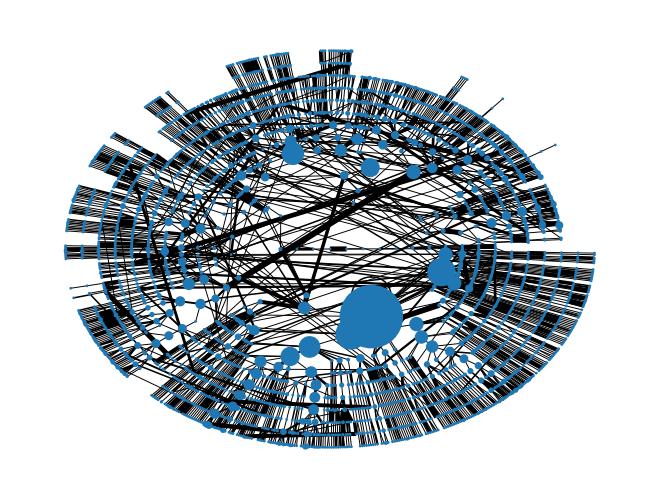

In [62]:
def plot_graph(graph):
    node_size = list(dict(graph.nodes.data("visit_count")).values())
    edge_size = list(map(lambda x: x[-1], graph.edges.data("visit_count"))) 
    node_size = np.array(node_size)
    edge_size = np.log(np.array(edge_size) + 1)
    pos = graphviz_layout(graph, prog="twopi")
    nx.draw(graph.to_undirected(), node_size=node_size, width=edge_size, pos=pos)
    plt.show()
    
plot_graph(nx.ego_graph(graph, start_fen, 10))

  0%|          | 0/300 [00:00<?, ?it/s]

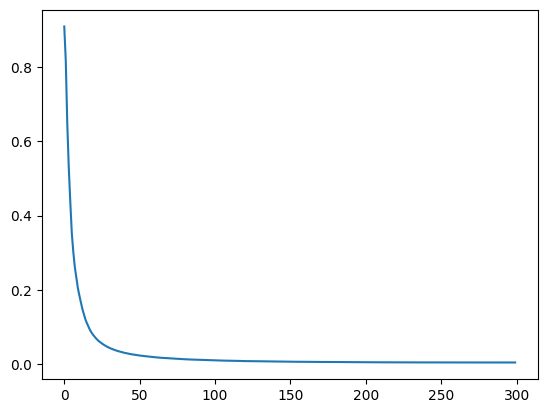

In [ ]:
leafs = np.zeros(DEPTH)
n_nodes = np.zeros(DEPTH)
for idx, r in enumerate(tqdm(range(1, DEPTH + 1))):
    ego_graph = nx.ego_graph(graph, start_fen, r)
    for node in ego_graph.nodes:
        if ego_graph.out_degree(node) == 0:
            leafs[idx] += 1
            
    n_nodes[idx] = len(ego_graph.nodes)

plt.plot(leafs / n_nodes)


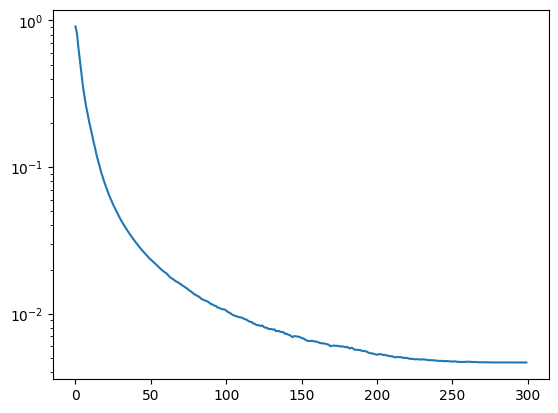

In [ ]:
plt.plot(leafs / n_nodes)
plt.yscale("log ")

In [1]:
plt.plot(leafs)
# plt.plot(n_nodes)
# plt.yscale("log")

NameError: name 'plt' is not defined

10


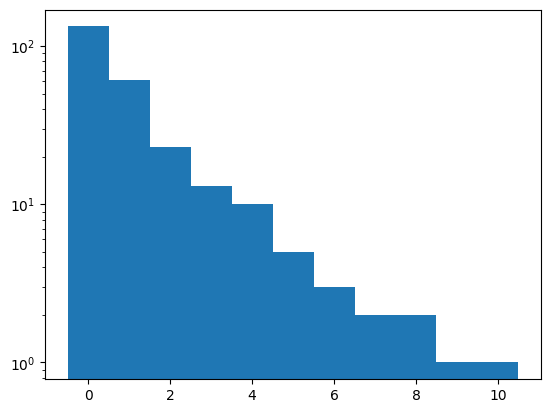

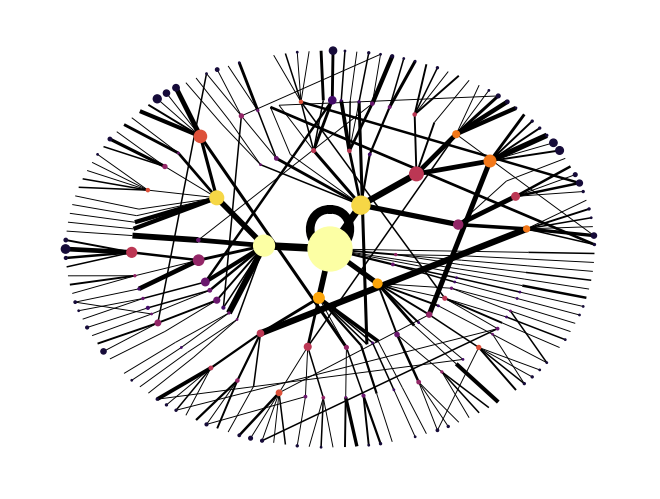

In [ ]:

# compute branching factor
import matplotlib as mpl

out_degrees = dict(graph.out_degree(graph))
values = np.array(list(out_degrees.values()))

max_degree = values.max()
print(max_degree)
bins = np.arange(max_degree + 2) - 0.5
counts, _ = np.histogram(values, bins=bins)
plt.bar(bins[:-1] + 0.5, counts, 1)
plt.yscale("log")
plt.show()

cmap = mpl.colormaps["inferno"]
colors = cmap(np.digitize(values, bins) / max_degree)
nx.draw(graph.to_undirected(), node_size=node_size - 1, width=edge_size, pos=pos, node_color    =colors)